In [52]:
import sys
import os
import platform
import importlib
import glob
import netCDF4
import numpy as np
import pandas as pd
from datetime import datetime

if platform.system() == 'Darwin':  # macOS
    base_FP = '/Users/hyunglokkim/Insync/hkim@geol.sc.edu/Google_Drive'
    cpuserver_data_FP = '/Users/hyunglokkim/cpuserver_data'
else:
    base_FP = '/data'
    cpuserver_data_FP = '/data'
sys.path.append(base_FP + '/python_modules')
print(base_FP, cpuserver_data_FP)

#hydroAI libs
import HydroAI.SMOS_CATDS as hSMOS_CATDS
import HydroAI.Grid as hGrid
import HydroAI.Plot as hPlot
import HydroAI.Data as hData
importlib.reload(hSMOS_CATDS);
importlib.reload(hGrid);
importlib.reload(hPlot);
importlib.reload(hData);

# Ignore runtime warnings
import warnings
warnings.filterwarnings("ignore")

# Define your directory where to save nc files
nc_save_dir = cpuserver_data_FP + '/extracted_nc'

/data /data


## 1. Import and save SMOS_CATDS SM

In [54]:
year = 2022
path = 'A'
directory = f'{cpuserver_data_FP}/SMOS_CATDS/{path}/{year}'  # Adjusting to match folders with '001', '002', ..., '365'
doy_year = (datetime(year+1, 1,1) - datetime(year, 1,1)).days

file_list = []
for day in range(1, doy_year + 1):
    day_str = f'{day:03}'  # Format day as '001', '002', ..., '365'
    day_directory = os.path.join(directory, day_str)
    file_list.extend(glob.glob(day_directory + '/*.nc'))  # Collecting all nc files from each day's folder

data_doy = np.arange(1, doy_year + 1)

print(np.shape(file_list), file_list[0])

# Check the grid size
with netCDF4.Dataset(file_list[0]) as nc_data:
    var_list = list(nc_data.variables.keys())
    print(var_list)
    nc_lat = nc_data.variables['lat'][:].data
    nc_lon = nc_data.variables['lon'][:].data

print(np.shape(nc_lat), np.shape(nc_lon))

longitude, latitude = hGrid.generate_lon_lat_e2grid('25km')
print(np.shape(latitude), np.shape(longitude))

(365,) /data/SMOS_CATDS/A/2022/001/SM_OPER_MIR_CLF31A_20220101T000000_20220101T235959_330_001_7.DBL.nc
['lat', 'lon', 'Mean_Acq_Time_Days', 'Mean_Acq_Time_Seconds', 'Mean_Acq_Time_Days2', 'Mean_Acq_Time_Seconds2', 'Soil_Moisture', 'Soil_Moisture_Dqx', 'Optical_Thickness_Nad', 'Optical_Thickness_Nad_Dqx', 'Optical_Thickness_Nad2', 'Optical_Thickness_Nad2_Dqx', 'Dielect_Const', 'Dielect_Const_Dqx', 'Hr', 'Hr_Dqx', 'Scattering_Albedo_H', 'Scattering_Albedo_H_Dqx', 'Diff_Albedos', 'Diff_Albedos_Dqx', 'Surface_Temperature', 'Surface_Temperature_Dqx', 'Temp_STL1', 'Temp_SKT', 'S_Tree_1', 'Tb_Toa_Theta_B_X', 'Tb_Toa_Theta_B_X_Dqx', 'Tb_Toa_Theta_B_Y', 'Tb_Toa_Theta_B_Y_Dqx', 'Tb_Asl_Theta_B_H', 'Tb_Asl_Theta_B_H_Dqx', 'Tb_Asl_Theta_B_V', 'Tb_Asl_Theta_B_V_Dqx', 'Science_Flags', 'Fno', 'Ffo', 'M_Ava0', 'M_Ava', 'N_Rfi_X', 'N_Rfi_Y', 'Min_Soil_Moisture', 'Max_Soil_Moisture', 'Min_Soil_Moisture_Dqx', 'Max_Soil_Moisture_Dqx', 'Soil_Moisture_Init_Val', 'Soil_Moisture_Init_Std', 'Gqx', 'Chi_2', 'Ch

In [44]:
# SM
SMOS_SM, _, _ = hSMOS_CATDS.create_array_from_nc(file_list, data_doy, year, 'Soil_Moisture')
print('SMOS_SM', np.shape(SMOS_SM))

# Tb related variables
Tb_var_list = ['Tb_Asl_Theta_B_H', 'Tb_Asl_Theta_B_H_Dqx', 'Tb_Asl_Theta_B_V', 'Tb_Asl_Theta_B_V_Dqx']
Tb_var_dict = {}
for Tb_var in Tb_var_list:
    Tb_var_dict[Tb_var], _, _ = hSMOS_CATDS.create_array_from_nc(file_list, data_doy, year, Tb_var)
    print(Tb_var, np.shape(Tb_var_dict[Tb_var]))

SMOS_SM (584, 1388, 366)
Tb_Asl_Theta_B_H (584, 1388, 366)
Tb_Asl_Theta_B_H_Dqx (584, 1388, 366)
Tb_Asl_Theta_B_V (584, 1388, 366)
Tb_Asl_Theta_B_V_Dqx (584, 1388, 366)


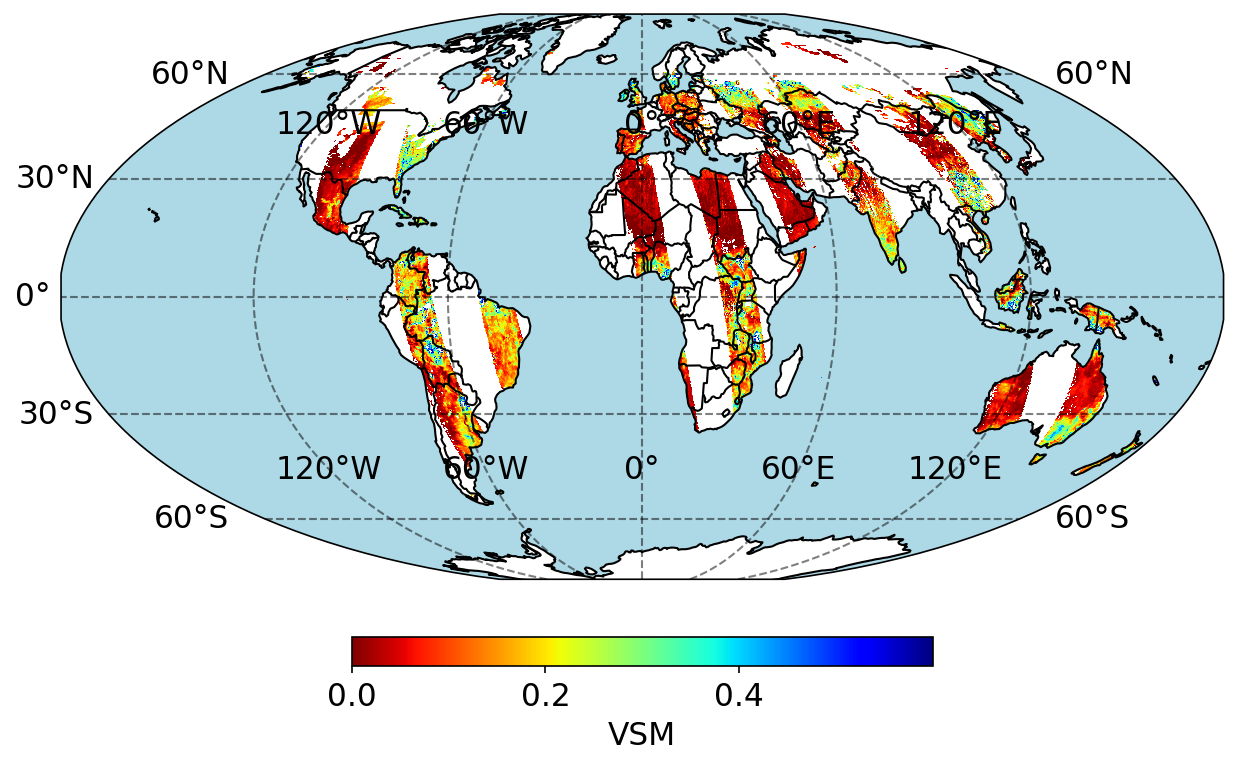

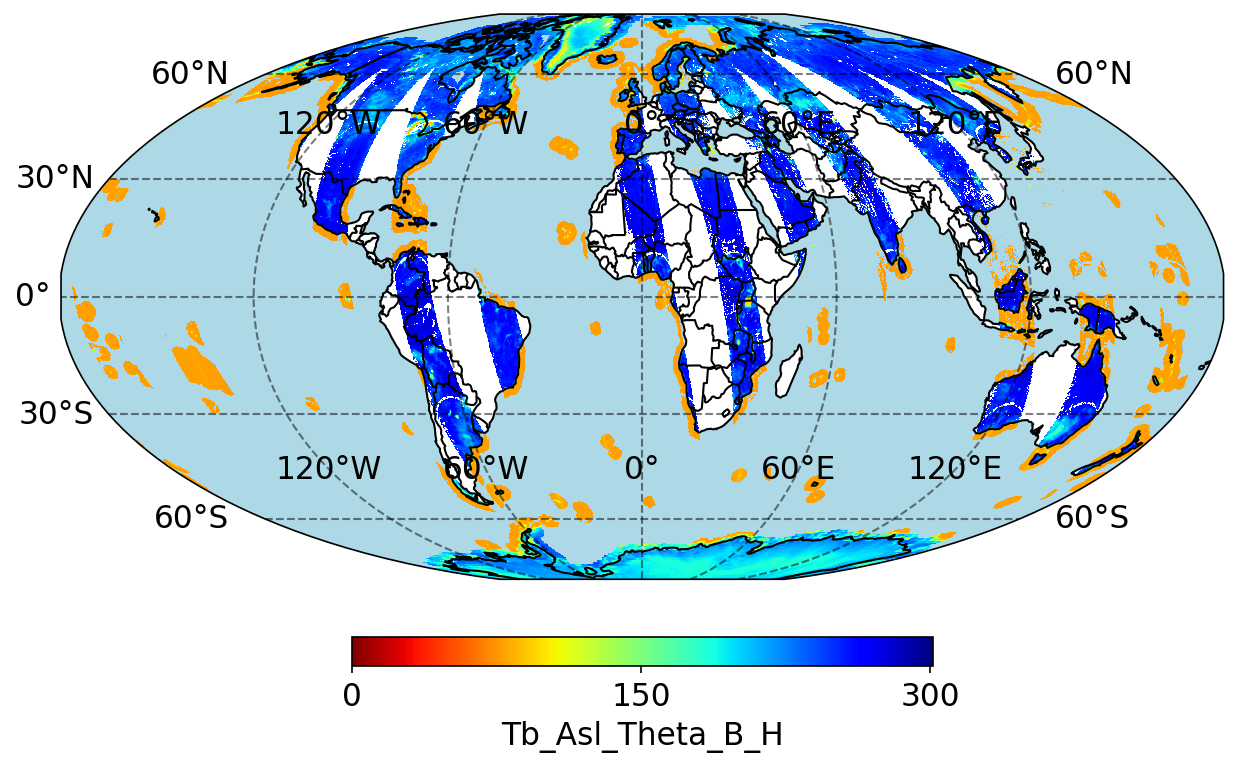

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [46]:
# Check the imported data
doy = 109
target = SMOS_SM
target[target > 0.6] = np.nan
hPlot.plot_map(longitude, latitude, target[:,:,doy], np.nanmin(target), np.nanmax(target), plot_title='SMOS SM', label_title='VSM', cmap='jet_r')

target = Tb_var_dict['Tb_Asl_Theta_B_H']
hPlot.plot_map(longitude, latitude, target[:,:,doy], np.nanmin(target), np.nanmax(target), plot_title='SMOS Tb_Asl_Theta_B_H', label_title='Tb_Asl_Theta_B_H', cmap='jet_r')

In [56]:
path_list = ['A'] #, 'D']
start_year = 2015
end_year = 2022 # 2023

for year in range(start_year, end_year + 1): 
    for path in path_list:
        print(year, path)
        directory = f'{cpuserver_data_FP}/SMOS_CATDS/{path}/{year}' 

        # doy of current year
        doy_year = (datetime(year+1, 1,1) - datetime(year, 1,1)).days

        file_list = []
        for day in range(1, doy_year + 1):
            day_str = f'{day:03}'
            day_directory = os.path.join(directory, day_str)
            file_list.extend(glob.glob(day_directory + '/*.nc'))  # Collecting all nc files from each day's folder

        data_doy = np.arange(1, doy_year + 1)

        # Import Variables
        # SM
        SMOS_SM, _, _ = hSMOS_CATDS.create_array_from_nc(file_list, data_doy, year, 'Soil_Moisture')
        print('SMOS_SM', np.shape(SMOS_SM))

        # Tb related variables
        Tb_var_list = ['Tb_Asl_Theta_B_H', 'Tb_Asl_Theta_B_H_Dqx', 'Tb_Asl_Theta_B_V', 'Tb_Asl_Theta_B_V_Dqx']
        Tb_var_dict = {}
        for Tb_var in Tb_var_list:
            Tb_var_dict[Tb_var], _, _ = hSMOS_CATDS.create_array_from_nc(file_list, data_doy, year, Tb_var)
            print(Tb_var, np.shape(Tb_var_dict[Tb_var]))

        # Create a NetCDF file
        path_time = 'am' if path == 'A' else 'pm'
        file_name = f'SMOS_CATDS_{year}_{path_time}.nc'
        nc_file_name = os.path.join(nc_save_dir, file_name)

        print(f"Saving: {nc_file_name}")
        hData.create_netcdf_file(
        nc_file=nc_file_name,
        latitude=latitude,
        longitude=longitude,
        SMOS_SM = SMOS_SM,
        **Tb_var_dict
        )

        print(f"NetCDF file created: {nc_file_name}")

2015 A
SMOS_SM (584, 1388, 366)
Tb_Asl_Theta_B_H (584, 1388, 366)
Tb_Asl_Theta_B_H_Dqx (584, 1388, 366)
Tb_Asl_Theta_B_V (584, 1388, 366)
Tb_Asl_Theta_B_V_Dqx (584, 1388, 366)
Saving: /data/extracted_nc/SMOS_CATDS_2015_am.nc
NetCDF file /data/extracted_nc/SMOS_CATDS_2015_am.nc created successfully.
NetCDF file created: /data/extracted_nc/SMOS_CATDS_2015_am.nc
2016 A
SMOS_SM (584, 1388, 367)
Tb_Asl_Theta_B_H (584, 1388, 367)
Tb_Asl_Theta_B_H_Dqx (584, 1388, 367)
Tb_Asl_Theta_B_V (584, 1388, 367)
Tb_Asl_Theta_B_V_Dqx (584, 1388, 367)
Saving: /data/extracted_nc/SMOS_CATDS_2016_am.nc
NetCDF file /data/extracted_nc/SMOS_CATDS_2016_am.nc created successfully.
NetCDF file created: /data/extracted_nc/SMOS_CATDS_2016_am.nc
2017 A
SMOS_SM (584, 1388, 366)
Tb_Asl_Theta_B_H (584, 1388, 366)
Tb_Asl_Theta_B_H_Dqx (584, 1388, 366)
Tb_Asl_Theta_B_V (584, 1388, 366)
Tb_Asl_Theta_B_V_Dqx (584, 1388, 366)
Saving: /data/extracted_nc/SMOS_CATDS_2017_am.nc
NetCDF file /data/extracted_nc/SMOS_CATDS_2017_am.n

IndexError: list index out of range

## 2. Resample SMOS-CATDS data
Korea domain with ERA5 land 0.10 degree resolution

In [63]:
target_projection = 'ERA5_land_010'

# Resample SMAP data into ERA5 Land 0.1 x 0.1 grid (Only Korea domain)
domain_nc_file = cpuserver_data_FP+'/ERA5/korea/ERA5_land_20100101.nc'
nc_data = netCDF4.Dataset(domain_nc_file)
domain_lon = nc_data.variables['longitude'][:]
domain_lat = nc_data.variables['latitude'][:]
nc_data.close()
domain_lon, domain_lat = np.meshgrid(domain_lon, domain_lat) # for 2D

# SMOS grid
SMOS_lon, SMOS_lat = hGrid.generate_lon_lat_e2grid('25km')

path_list = ['am'] #, 'pm']
for year in range(start_year, end_year + 1):
    for path in path_list:
        # resample SMOS into the doamin size
        nc_file  = nc_save_dir+'/SMOS_CATDS_'+str(year)+'_'+path+'.nc'
        print(nc_file)
        nc_data  = netCDF4.Dataset(nc_file)

        resampled_vars_dict = {}

        SMOS_SM  = nc_data.variables['SMOS_SM'][:].data
        Resampled_SMOS_SM    = hData.Resampling_forloop(domain_lon, domain_lat, SMOS_lon, SMOS_lat, SMOS_SM,
                                                        sampling_method='nearest', agg_method='mean', mag_factor=3)
        resampled_vars_dict['Resampled_SMOS_SM'] = Resampled_SMOS_SM

        for Tb_var in Tb_var_list:
            Tb_var_data = nc_data.variables[Tb_var][:].data
            Resampled_Tb_var = hData.Resampling_forloop(domain_lon, domain_lat, SMOS_lon, SMOS_lat, Tb_var_data,
                                                        sampling_method='nearest', agg_method='mean', mag_factor=3)
            resampled_vars_dict[f'Resampled_{Tb_var}'] = Resampled_Tb_var

        nc_data.close()
       
        file_name = 'SMOS_CATDS_'+str(year)+'_'+path+'_R_'+target_projection+'.nc'
        nc_file_name = nc_save_dir+'/'+file_name
        
        print(f"Saving: {nc_file}")
        hData.create_netcdf_file(
        nc_file    = nc_file_name,
        latitude   = domain_lat,
        longitude  = domain_lon,
        **resampled_vars_dict
        )

        print(f"NetCDF file created: {nc_file}")

Processing row 0/584
Processing row 100/584
Processing row 200/584
Processing row 300/584
Processing row 400/584
Processing row 500/584
/data/extracted_nc/SMOS_CATDS_2015_am.nc


100%|██████████| 366/366 [02:07<00:00,  2.88it/s]


Saving: /data/extracted_nc/SMOS_CATDS_2015_am.nc
NetCDF file /data/extracted_nc/SMOS_CATDS_2015_am_R_ERA5_land_010.nc created successfully.
NetCDF file created: /data/extracted_nc/SMOS_CATDS_2015_am.nc
/data/extracted_nc/SMOS_CATDS_2016_am.nc


100%|██████████| 367/367 [02:07<00:00,  2.88it/s]


Saving: /data/extracted_nc/SMOS_CATDS_2016_am.nc
NetCDF file /data/extracted_nc/SMOS_CATDS_2016_am_R_ERA5_land_010.nc created successfully.
NetCDF file created: /data/extracted_nc/SMOS_CATDS_2016_am.nc
/data/extracted_nc/SMOS_CATDS_2017_am.nc


100%|██████████| 366/366 [02:06<00:00,  2.88it/s]


Saving: /data/extracted_nc/SMOS_CATDS_2017_am.nc
NetCDF file /data/extracted_nc/SMOS_CATDS_2017_am_R_ERA5_land_010.nc created successfully.
NetCDF file created: /data/extracted_nc/SMOS_CATDS_2017_am.nc
/data/extracted_nc/SMOS_CATDS_2018_am.nc


100%|██████████| 366/366 [02:06<00:00,  2.89it/s]


Saving: /data/extracted_nc/SMOS_CATDS_2018_am.nc
NetCDF file /data/extracted_nc/SMOS_CATDS_2018_am_R_ERA5_land_010.nc created successfully.
NetCDF file created: /data/extracted_nc/SMOS_CATDS_2018_am.nc
/data/extracted_nc/SMOS_CATDS_2019_am.nc


100%|██████████| 366/366 [02:06<00:00,  2.89it/s]


Saving: /data/extracted_nc/SMOS_CATDS_2019_am.nc
NetCDF file /data/extracted_nc/SMOS_CATDS_2019_am_R_ERA5_land_010.nc created successfully.
NetCDF file created: /data/extracted_nc/SMOS_CATDS_2019_am.nc
/data/extracted_nc/SMOS_CATDS_2020_am.nc


100%|██████████| 367/367 [02:06<00:00,  2.89it/s]


Saving: /data/extracted_nc/SMOS_CATDS_2020_am.nc
NetCDF file /data/extracted_nc/SMOS_CATDS_2020_am_R_ERA5_land_010.nc created successfully.
NetCDF file created: /data/extracted_nc/SMOS_CATDS_2020_am.nc
/data/extracted_nc/SMOS_CATDS_2021_am.nc


100%|██████████| 366/366 [02:06<00:00,  2.90it/s]


Saving: /data/extracted_nc/SMOS_CATDS_2021_am.nc
NetCDF file /data/extracted_nc/SMOS_CATDS_2021_am_R_ERA5_land_010.nc created successfully.
NetCDF file created: /data/extracted_nc/SMOS_CATDS_2021_am.nc
/data/extracted_nc/SMOS_CATDS_2022_am.nc


100%|██████████| 366/366 [02:06<00:00,  2.89it/s]

Saving: /data/extracted_nc/SMOS_CATDS_2022_am.nc
NetCDF file /data/extracted_nc/SMOS_CATDS_2022_am_R_ERA5_land_010.nc created successfully.
NetCDF file created: /data/extracted_nc/SMOS_CATDS_2022_am.nc
/data/extracted_nc/SMOS_CATDS_2023_am.nc


FileNotFoundError: [Errno 2] No such file or directory: b'/data/extracted_nc/SMOS_CATDS_2023_am.nc'

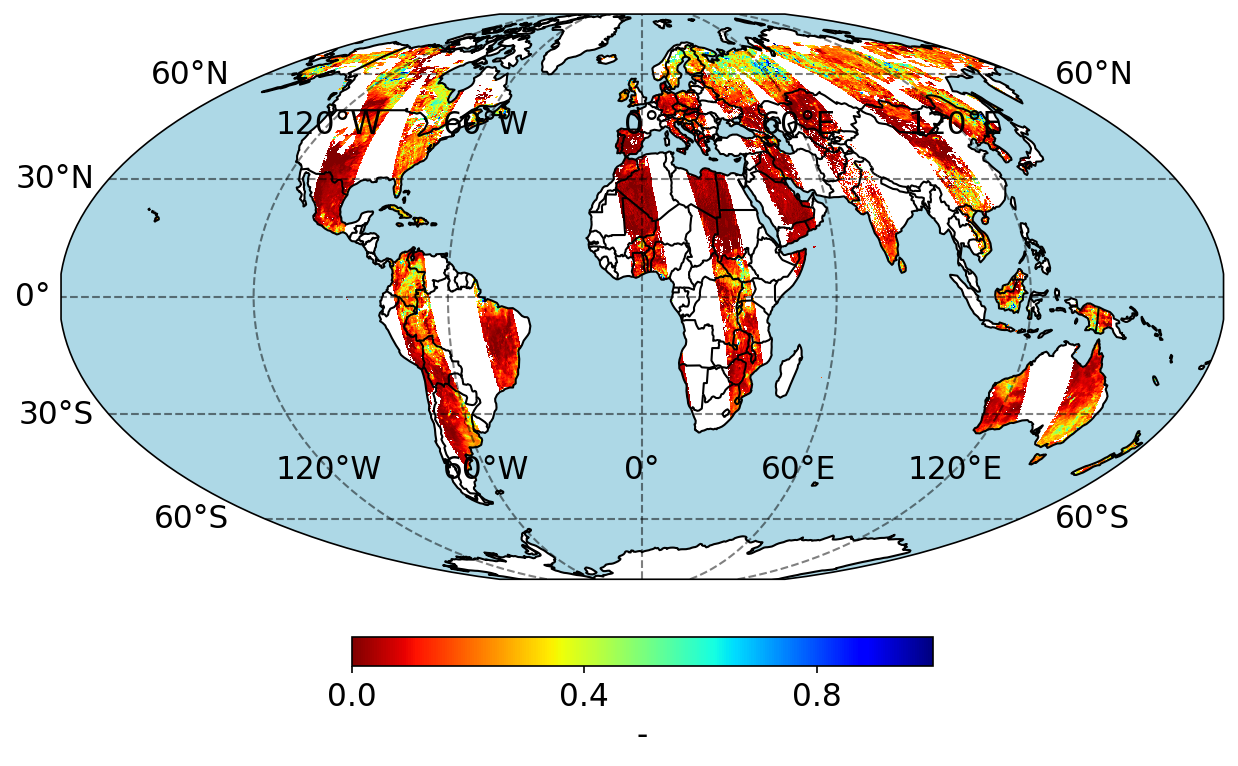

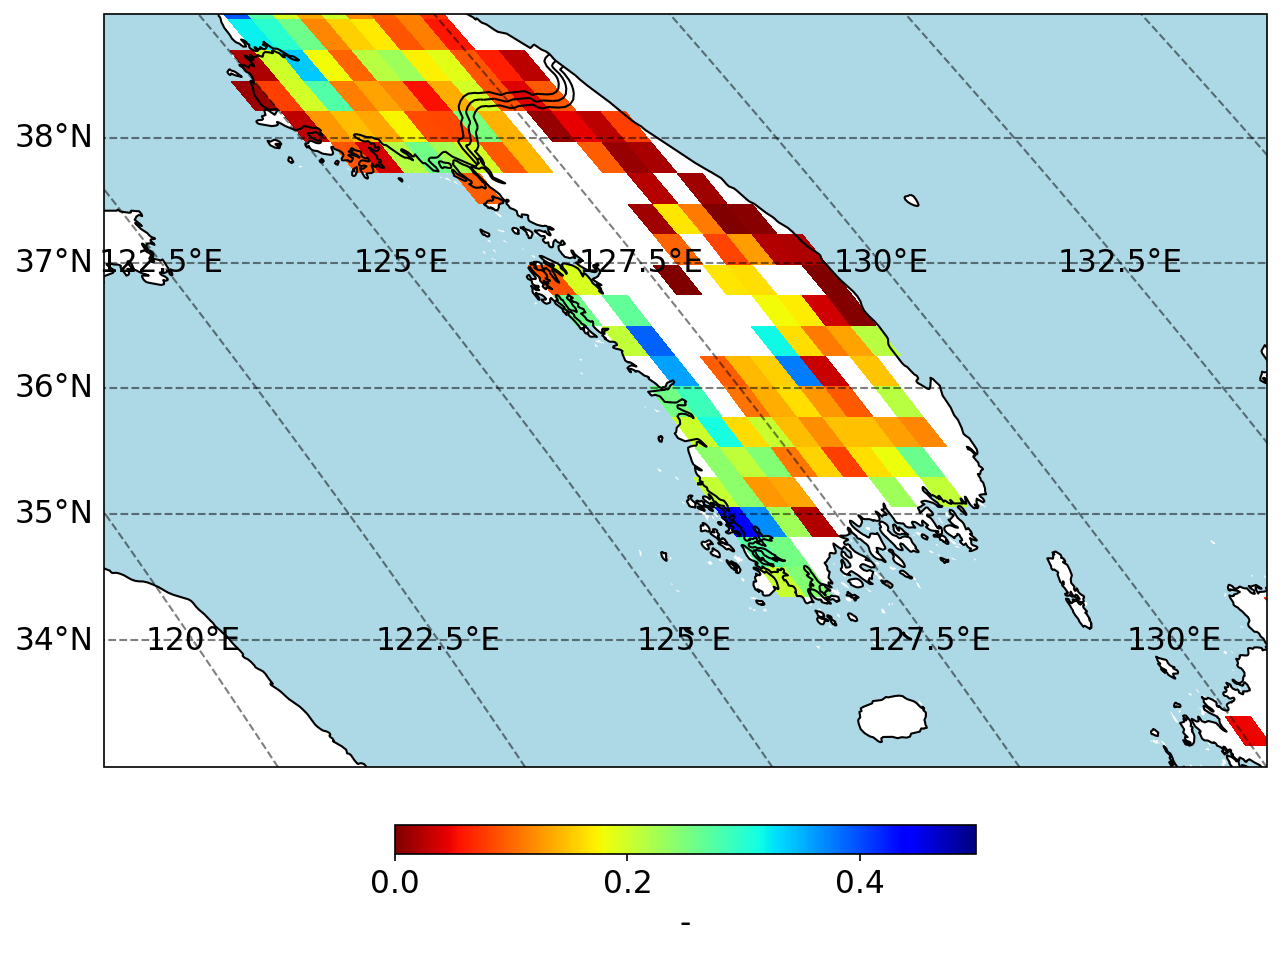

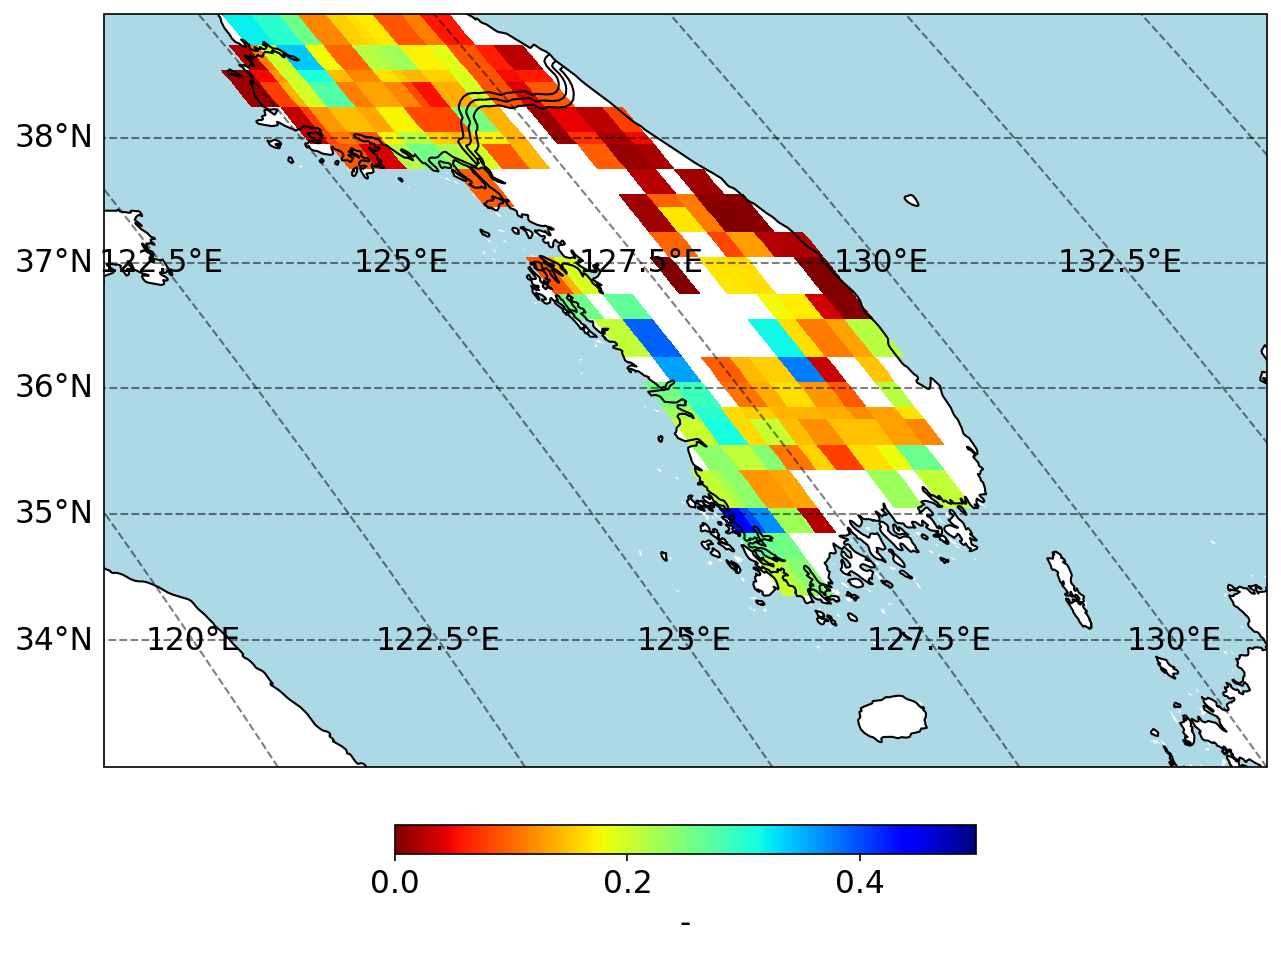

(<Figure size 1500x1500 with 2 Axes>, <GeoAxes: >)

In [65]:
doy = 150

target = SMOS_SM[:,:, doy]
hPlot.plot_map(SMOS_lon, SMOS_lat, target, np.nanmin(target), np.nanmax(target), plot_title='SMOS SM', label_title='-', cmap='jet_r')

target = SMOS_SM[:,:,doy]
hPlot.plot_map(SMOS_lon, SMOS_lat, target, 0, 0.5, plot_title='SMOS SM (Korea domain)', label_title='-', cmap='jet_r',
               bounds=[domain_lon[0,0], domain_lon[-1,-1], domain_lat[0,0], domain_lat[-1,-1]]) # Korea domain

target = Resampled_SMOS_SM[:,:,doy]
hPlot.plot_map(domain_lon, domain_lat, target, 0, 0.5, plot_title='Resampled SMOS SM', label_title='-', cmap='jet_r')